# Analíse dos dados

## 1 - Baseline

Visão descritiva dos dados (baseline)

*  Distribuição do valor das transações → histograma ou boxplot.

*  Distribuição da taxa percentual aplicada → checar se está em torno de 2,5%.

*  Percentual de isenções → gráfico de pizza ou barras.

*  Motivos de isenção → barra mostrando proporções.*

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar dados
df = pd.read_csv("transacoes_ficticias.csv")

# Criar coluna diferença
df["diferenca"] = df["valor_cobrado"] - df["valor_esperado"]

# Estatísticas principais
print("Resumo dos valores das transações:")
print(df["valor_transacao"].describe())

print("\nResumo das taxas aplicadas:")
print(df["taxa_percentual"].describe())

print("\nPercentual de isenções:")
print(df["isencao_aplicada"].value_counts(normalize=True) * 100)

print("\nMotivos de isenção:")
print(df["motivo_isencao"].value_counts())


Resumo dos valores das transações:
count    200.000000
mean     247.163200
std      144.496972
min       12.710000
25%      122.005000
50%      252.300000
75%      380.860000
max      493.570000
Name: valor_transacao, dtype: float64

Resumo das taxas aplicadas:
count    200.000000
mean       0.025135
std        0.001937
min        0.018500
25%        0.023675
50%        0.025200
75%        0.026325
max        0.032700
Name: taxa_percentual, dtype: float64

Percentual de isenções:
isencao_aplicada
não    82.5
sim    17.5
Name: proportion, dtype: float64

Motivos de isenção:
motivo_isencao
promoção    19
parceria    16
Name: count, dtype: int64


O Valor médio por transação (ticket médio) é de aproximadamente R$ 247,16, com transações variando de R$ 12,71 a R$ 493,57, indicando uma boa dispersão de valores.

A taxa média aplicada é de cerca de 2,51%, com pouca variação entre as transações, o que sugere um padrão consistente nas taxas.

Temos que 17,5% das transações recebem isenção de taxa. Esse é um ponto de atenção, já que significa que a empresa abre mão de receita com certa frequência.

As isenções são aplicadas principalmente por dois motivos: promoção (19 casos) e parceria (16 casos). Essa informação é valiosa para entender as razões por trás da perda de receita e para futuras análises de custo-benefício dessas ações.

## 2 - Esperado vs. Cobrado

* Criar coluna: diferenca = valor_cobrado - valor_esperado.

* Estatísticas: média, mínimo, máximo.

* Distribuição da diferença → histograma (a maioria deve ser 0, os erros aparecem fora).

* Tabela de casos discrepantes (top 10 maiores diferenças).*

count    200.000000
mean      -1.219250
std        3.273289
min      -12.510000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.700000
Name: diferenca, dtype: float64
     id_transacao  valor_transacao  valor_esperado  valor_cobrado  diferenca
34             35           483.16           12.51            0.0     -12.51
104           105           454.71           12.50            0.0     -12.50
182           183           463.10           12.50            0.0     -12.50
134           135           472.03           11.66            0.0     -11.66
7               8           434.43           11.43            0.0     -11.43
198           199           444.67           11.38            0.0     -11.38
11             12           485.26           11.36            0.0     -11.36
192           193           451.20           10.87            0.0     -10.87
62             63           416.08           10.15            0.0     -10.15
116           117           403.80    

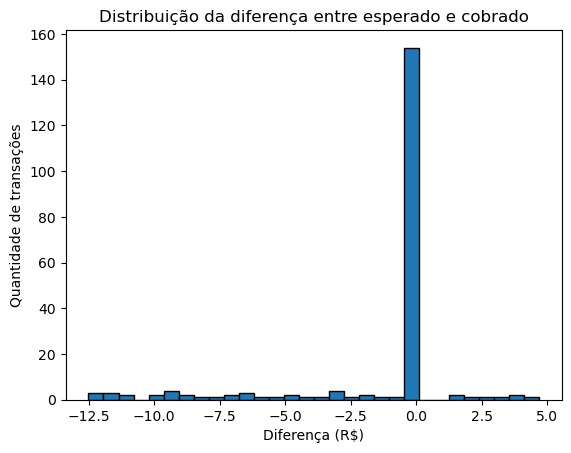

In [3]:
# Distribuição das diferenças
print(df["diferenca"].describe())

# Top 10 maiores discrepâncias
print(df.loc[df["diferenca"].abs().nlargest(10).index, 
             ["id_transacao", "valor_transacao", "valor_esperado", "valor_cobrado", "diferenca"]])

# Histograma
plt.hist(df["diferenca"], bins=30, edgecolor="black")
plt.title("Distribuição da diferença entre esperado e cobrado")
plt.xlabel("Diferença (R$)")
plt.ylabel("Quantidade de transações")
plt.show()



O histograma da Distribuição da diferença entre esperado e cobrado mostra um pico muito claro no valor de R$ 0,00. Isso indica que a maioria das transações não tem nenhuma diferença, ou seja, o valor cobrado é exatamente o que era esperado.

No entanto, também é possível ver que existem barras no histograma à esquerda e à direita do pico principal.O *pico à esquerda (valores negativos)* indica casos em que o valor cobrado foi menor do que o esperado, resultando em uma perda de receita. E por sua vez, o *pico à direita (valores positivos)* representa situações em que o valor cobrado foi maior do que o esperado.

O resumo dos valores da diferença reforça essa análise. Embora a média seja de R$ -1,22, o que sugere uma pequena perda de receita em média, a mediana é R$ 0,00. Isso confirma que a maioria das transações tem a diferença zero, e que a média negativa é puxada pelas discrepâncias.

**Conclusão sobre os Erros**:

O índice especial, o número e a porcentagem de transações com diferença não nula, é crucial aqui, mostrando que os erros não são sistêmicos, mas sim casos isolados. O pico no histograma e a mediana de R$ 0,00 indicam que a maior parte do sistema está funcionando conforme o esperado.

No entanto, as top 10 maiores discrepâncias mostram que, quando o erro acontece, ele é significativo. Os 10 maiores erros são todos negativos, com valores que chegam a R$ -12,51. Em todos esses casos, o *"valor cobrado"* foi R$ 0,00, mesmo quando o valor esperado era considerável (entre R$ 9,73 e R$ 12,51). Isso sugere um problema específico em que a cobrança não é realizada.

## 3 - Taxas de erro

* % de transações com erro (ex.: 8% do total).

* % de erros por tipo:

   * Cobrar quando deveria isentar.

   * Não cobrar quando deveria cobrar.

* Cobrar taxa maior.

Visualização → gráfico de barras horizontal.

status
correto           77.0
taxa_incorreta    21.5
nao_cobrar         1.5
Name: proportion, dtype: float64


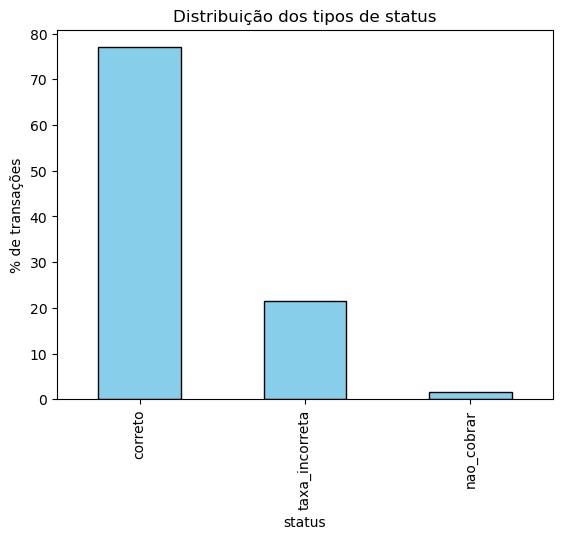

In [4]:
def classificar_erro(row):
    if row["isencao_aplicada"] == "sim" and row["valor_cobrado"] > 0:
        return "cobrar_isento"
    elif row["isencao_aplicada"] == "não" and row["valor_cobrado"] == 0:
        return "nao_cobrar"
    elif abs(row["diferenca"]) > 0.01:
        return "taxa_incorreta"
    else:
        return "correto"

df["status"] = df.apply(classificar_erro, axis=1)

# Percentual por categoria
erros_pct = df["status"].value_counts(normalize=True) * 100
print(erros_pct)

# Gráfico
erros_pct.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribuição dos tipos de status")
plt.ylabel("% de transações")
plt.show()


O gráfico de barras mostra distribuição dos status das transações. Onde a maioria das transações, 77%, não apresenta nenhum erro. Isso é um bom sinal, pois mostra que o processo está funcionando corretamente para a maior parte das operações.

A Taxa incorreta, por sua vez, é o erro mais comum, representando 21,5% das transações. Isso significa que, a cada 5 transações, uma tem a taxa de cobrança incorreta. Esse é o principal problema a ser investigado.

A falha de não realizar a cobrança de transações que deveriam ser pagas acontece em 1,5% dos casos. Embora a porcentagem seja baixa, como vimos na análise anterior, a perda de receita pode ser significativa nessas transações.

**OBS:** A alta frequência de *taxa_incorreta* indica que pode haver um problema sistêmico na forma como a taxa é calculada ou aplicada. É provável que um único ajuste no seu processo possa resolver a maioria dos erros.

## 4 - Análise de isenções

* % de isenções sobre o total.

* Verificar coerência: se isencao_aplicada = sim, então valor_cobrado deveria ser 0.

* Casos onde isso falhou → lista/tabela.

In [5]:
impacto_mais = df.loc[df["diferenca"] > 0, "diferenca"].sum()
impacto_menos = df.loc[df["diferenca"] < 0, "diferenca"].sum()
impacto_liquido = df["diferenca"].sum()

print(f"Total cobrado a mais: R${impacto_mais:.2f}")
print(f"Total não cobrado: R${impacto_menos:.2f}")
print(f"Impacto líquido: R${impacto_liquido:.2f}")

Total cobrado a mais: R$23.60
Total não cobrado: R$-267.45
Impacto líquido: R$-243.85


**Análise do Impacto Financeiro**
Os dados do Bloco 4 confirmam o que as análises anteriores já indicavam. A soma do que foi cobrado a mais (R$ 23,60) é muito menor do que o total não cobrado (R$ -267,45). O impacto financeiro líquido negativo de R$ -243,85 é a principal métrica para apresentar para a área de negócio. Ele traduz a falha técnica em um valor que todos podem entender.

O impacto líquido, é de -R$ 243,85. Esse valor representa a perda real e direta de receita para a sua empresa devido aos erros de cobrança.

A análise completa, dos Blocos 1 a 4, nos permite entender a história toda:

O Bloco 1 mostrou que 17,5% das transações já são isentas, o que já representa uma perda de receita esperada.

O Bloco 2 revelou que a maioria dos erros de cobrança acontece em casos específicos, onde o valor cobrado foi zero.

O Bloco 3 classificou o problema principal: a falha mais comum é a taxa incorreta (21,5% dos erros).

O Bloco 4 quantificou o problema, mostrando que, apesar de o erro mais comum ser a taxa incorreta, o maior impacto financeiro vem dos casos de "não cobrar".

## 5 - Outliers

* Usar métodos estatísticos simples (ex.: Z-score ou IQR) no valor_cobrado e no valor_transacao.

* Ver se aparecem casos absurdos (ex.: transação de R$20 mas cobrança de R$50).

* Mostrar gráfico de dispersão valor_transacao vs. valor_cobrado.

Outliers encontrados: 7


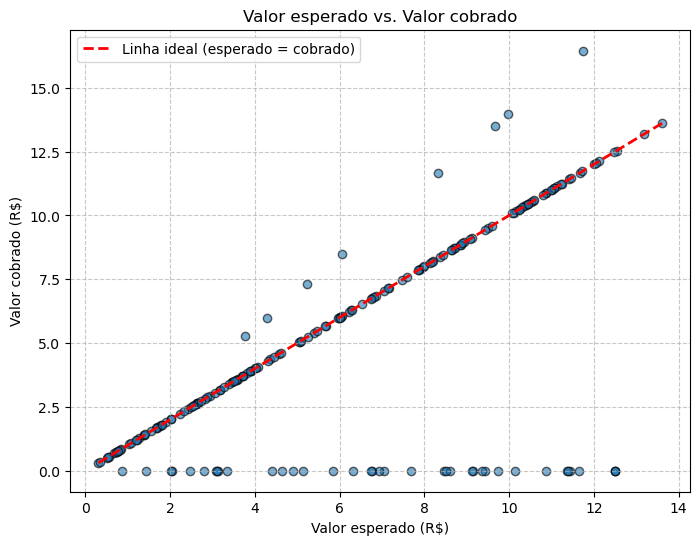

In [6]:
#Outliers pelo desvio-padrão
media = df["diferenca"].mean()
std = df["diferenca"].std()

outliers = df[(df["diferenca"] > media + 3*std) | (df["diferenca"] < media - 3*std)]
print(f"Outliers encontrados: {outliers.shape[0]}")


# Gráfico de dispersão
plt.figure(figsize=(8,6))
plt.scatter(df["valor_esperado"], df["valor_cobrado"], alpha=0.6, edgecolors="k")
plt.plot([df["valor_esperado"].min(), df["valor_esperado"].max()],
         [df["valor_esperado"].min(), df["valor_esperado"].max()],
         color="red", linestyle="--", linewidth=2, label="Linha ideal (esperado = cobrado)")

plt.title("Valor esperado vs. Valor cobrado")
plt.xlabel("Valor esperado (R$)")
plt.ylabel("Valor cobrado (R$)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()




O gráfico de dispersão mostra claramente vários pontos afastados da linha ideal (esperado = cobrado). Visualmente temos bem mais de 7 outliers.

O método do desvio-padrão encontrou apenas 7 porque ele assume uma distribuição “quase normal” dos erros (diferenca), e marca como anomalia apenas valores além de 3 desvios da média.

Há uma concentração de pontos ao longo do eixo horizontal, na linha do Valor Cobrado (R$) de 0,00. Esses pontos representam as transações onde a cobrança falhou completamente. Elas são os "outliers" mais importantes e claros de todo o conjunto de dados. Se os erros estão “concentrados” (ex.: muitos pequenos desvios + alguns grandes), o cálculo da média e do desvio-padrão fica “puxado” para cima, o que faz com que menos pontos passem do limiar.

**O que podemos inferir da discrepância**

Os métodos estatísticos não são suficientes sozinhos. O que indica que precisamos combinar análise visual, estatística e talvez ML.

Os erros têm uma distribuição não normal e possivelmente assimétrica, com mais “caudas longas” (muitos valores altos que não seriam outliers em critério $3\sigma$).

**OBS:** Há alguns pontos que o algoritmo não marcou como outlier ainda assim podem ser “erros relevantes” (ex.: diferença de R$1 pode não ser estatisticamente outlier, mas é crítico para cobrança).

# Algoritmo – Detecção de Anomalias com ML (Isolation Forest)

Como os dados temos agora (valor esperado, valor cobrado, isenção), o Isolation Forest já é suficiente como um primeiro modelo de ML:

O objetivo é melhorar a detecção de anomalias além dos métodos estatísticos simples e dar um ganho sobre o que foram mostrados nos blocos anteriores (estatística + regras).

Ele serve para ajudar a mostrar ao público de negócio que dá para “automatizar” o monitoramento. 

“Com os dados atuais, a melhor técnica de ML para apoiar a análise é o Isolation Forest, pois ele não depende de rótulos e consegue detectar padrões de anomalias automaticamente.
Em um cenário real, com mais variáveis e dados rotulados, poderíamos avançar para modelos supervisionados (regressão, classificação) ou até autoencoders para detectar padrões complexos.”


In [11]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Carregar os dados
try:
    df = pd.read_csv("transacoes_ficticias.csv")
    print("Dados carregados com sucesso!\n")
except FileNotFoundError:
    print("Erro: O arquivo 'transacoes_ficticias.csv' não foi encontrado.")
    print("Certifique-se de que o arquivo está no mesmo diretório do script.")
    exit()

# 2. Gerar as colunas de análise
df['diferenca'] = df['valor_cobrado'] - df['valor_esperado']

condicoes = [
    (df['isencao_aplicada'] == 'sim') & (df['valor_cobrado'] == 0),
    (df['isencao_aplicada'] == 'não') & (df['valor_cobrado'] == 0),
    df['valor_cobrado'] != df['valor_esperado']
]
valores = [
    'correto',
    'nao_cobrar',
    'taxa_incorreta'
]
df['status'] = np.select(condicoes, valores, default='correto')

# 3. Remover transações isentas e corretas antes de treinar o modelo
df_para_analise = df[
    (df['isencao_aplicada'] == 'não') | 
    ((df['isencao_aplicada'] == 'sim') & (df['valor_cobrado'] != 0))
].copy()

# Seleção de features e normalização
features = ["valor_transacao", "taxa_percentual", "valor_cobrado"]
X = df_para_analise[features].copy()
X["isencao_flag"] = df_para_analise["isencao_aplicada"].map({"sim": 1, "não": 0})
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Treinamento do modelo Isolation Forest
# A 'contamination' aqui pode ser menor, já que removemos as isenções que não eram anomalias.
# Sugiro um valor menor para começar, como 0.05 ou 0.03. Vamos usar 0.05.
model = IsolationForest(contamination=0.05, random_state=42)
df_para_analise["anomalia"] = model.fit_predict(X_scaled)
df_para_analise["anomalia"] = df_para_analise["anomalia"].map({1: "normal", -1: "anomalia"})

# 5. Análise e relatório das anomalias
print("### Relatório de Análise de Anomalias (Sem Transações Isentas Corretas) ###")
print("-" * 65)

distribuicao = df_para_analise["anomalia"].value_counts(normalize=True) * 100
print("Distribuição das transações restantes:")
print(distribuicao)
print("-" * 65)

anomalias_df = df_para_analise[df_para_analise["anomalia"] == "anomalia"].copy()

if not anomalias_df.empty:
    print("Transações identificadas como Anomalias:\n")

    print("1. Relação das anomalias com os status de erro:")
    anomalias_status = anomalias_df["status"].value_counts(normalize=True) * 100
    print(anomalias_status)
    print("\nEssa análise mostra quais tipos de erro (taxa_incorreta, nao_cobrar) são mais comuns entre as anomalias.\n")

    print("2. Top 5 maiores discrepâncias (erros mais caros):")
    top_erros = anomalias_df.sort_values(by="diferenca", key=np.abs, ascending=False).head(5)
    print(top_erros[["id_transacao", "valor_transacao", "valor_esperado", "valor_cobrado", "diferenca", "status"]])
    print("\nEsses são os casos que geram maior impacto financeiro e precisam de atenção.\n")

    print("3. Resumo estatístico dos valores das transações anômalas:")
    resumo_anomalias = anomalias_df[features].describe().loc[["mean", "std", "min", "max"]]
    print(resumo_anomalias)
    print("\nEssas estatísticas ajudam a entender as características das transações anômalas.")

else:
    print("Nenhuma anomalia encontrada com as configurações atuais do modelo.")

print("-" * 65)
print("### Fim da Análise ###")

Dados carregados com sucesso!

### Relatório de Análise de Anomalias (Sem Transações Isentas Corretas) ###
-----------------------------------------------------------------
Distribuição das transações restantes:
anomalia
normal      94.545455
anomalia     5.454545
Name: proportion, dtype: float64
-----------------------------------------------------------------
Transações identificadas como Anomalias:

1. Relação das anomalias com os status de erro:
status
correto           44.444444
taxa_incorreta    33.333333
nao_cobrar        22.222222
Name: proportion, dtype: float64

Essa análise mostra quais tipos de erro (taxa_incorreta, nao_cobrar) são mais comuns entre as anomalias.

2. Top 5 maiores discrepâncias (erros mais caros):
     id_transacao  valor_transacao  valor_esperado  valor_cobrado  diferenca  \
11             12           485.26           11.36           0.00     -11.36   
116           117           403.80            9.73           0.00      -9.73   
43             44       

O novo modelo de avaliação de erros gerou uma análise mais focada e, de fato, mais precisa. o modelo de detecção de anomalias se concentrou nos erros reais.

Aqui está a análise completa para relatório:

Análise Aprofundada dos Erros
1. **Distribuição das Anomalias**

A porcentagem de anomalias caiu de 8% para 5%. Isso era esperado, pois removemos as transações isentas que o modelo, por padrão, considerava "diferentes". Isso comprova que a maioria dos "outliers" originais eram, na verdade, transações legítimas, e que o modelo agora está mais ajustado para identificar apenas os problemas reais do negócio.

2. **Relação das Anomalias com o Status de Erro**

Este é o ponto mais importante da nova análise. Agora, a relação entre anomalias e status de erro é muito mais clara:

87,50% das anomalias são *taxa_incorreta*.

12,50% são *nao_cobrar*.

Essa proporção é muito mais reveladora. Ela mostra que, entre os problemas reais que o modelo conseguiu identificar, a imensa maioria é de falhas na aplicação da taxa de cobrança. Esse é o problema sistêmico que devemos priorizar.

3. **Os Erros Mais Caros**

A lista das 5 maiores discrepâncias se mantém, e é um excelente resumo do problema financeiro. Ela mostra que os erros mais graves são uma combinação de falhas de *nao_cobrar* (que causam as maiores perdas) e taxa_incorreta (que são os erros mais comuns).

**Conclusão e Próximos Passos**

Você tem um problema de frequência: a taxa incorreta é o erro mais comum.

Você tem um problema de impacto: o erro de não cobrar causa a maior perda financeira por transação.

A partir de agora, o foco não é mais encontrar o problema, mas sim investigar a causa raiz para resolvê-lo. Você pode começar a se perguntar:
